# Notebook de Teste de Algoritmos Genéticos Matriciais

## Imports

In [12]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from src.data.loader import DataLoader
from src.data.preprocessor import preprocess_dataset
from src.algorithms.knn_classifier import KNNClassifier
from src.algorithms.genetic_algorithm import GeneticAlgorithm
from src.algorithms.matrix_ga import MatrixGeneticAlgorithm
from src.fitness.accuracy_fitness import create_fitness_function

sns.set_style('whitegrid')
np.random.seed(42)

## Testes

In [ ]:
loader = DataLoader(data_root='../data/raw')
X_train_raw, y_train_raw, X_test_raw, y_test_raw = loader.load_ovarian()

X = np.vstack([X_train_raw, X_test_raw])
y = np.concatenate([y_train_raw, y_test_raw])

print(f"Dataset Colon:")
print(f"  Samples: {X.shape[0]}")
print(f"  Features: {X.shape[1]}")

Carregando conjunto de dados de microarray: COLON-TUMOR
Formato Elvira detectado
Parseando arquivo Elvira: colonTumor.dbc
Número de casos esperados: 62
Encontrados 2001 nós/variáveis
Nó de label: SampleType
Estados do label: ['positive', 'negative']
Extraídos 62 casos
Mapeamento de labels: {'positive': 0, 'negative': 1}
Matriz de dados: X=(62, 2000), y=(62,)
Classes únicas em y: [0 1] (distribuição: [22 40])
Conjunto de dados COLON-TUMOR carregado com sucesso. X_train: (43, 2000), X_test: (19, 2000)
Features: 2000, Samples: 62, Classes: 2
Dataset Colon:
  Samples: 62
  Features: 2000


In [14]:
X_train, X_test, y_train, y_test = preprocess_dataset(
    X, y, 
    normalization='standard',
    test_size=0.3, 
    random_state=42
)

print(f"\nConjunto de treino: {X_train.shape}")
print(f"Conjunto de teste: {X_test.shape}")

Dados normalizados com standard
Shape: (62, 2000), Min: -2.0202, Max: 7.4755
Divisão treino/teste: 70/30
Treino: (43, 2000), Teste: (19, 2000)
Distribuição treino: [15 28]
Distribuição teste: [ 7 12]

Conjunto de treino: (43, 2000)
Conjunto de teste: (19, 2000)


In [15]:
knn_baseline = KNNClassifier(k=7, distance_metric='euclidean')
knn_baseline.fit(X_train, y_train)

acc_train_baseline = knn_baseline.score(X_train, y_train)
acc_test_baseline = knn_baseline.score(X_test, y_test)

print(f"KNN Baseline (k=7, todas as features):")
print(f"  Acurácia Treino: {acc_train_baseline:.4f}")
print(f"  Acurácia Teste: {acc_test_baseline:.4f}")

KNN Baseline (k=7, todas as features):
  Acurácia Treino: 0.8837
  Acurácia Teste: 0.8421


In [16]:
fitness_function = create_fitness_function(
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    k=7,
    metric='euclidean',
    penalty_weight=0.0
)

In [17]:
ga_basic = GeneticAlgorithm(
    population_size=200,
    generations=50,
    crossover_rate=0.8,
    mutation_rate=0.05,
    tournament_size=5,
    elitism=5,
    random_state=None
)

print("Executando GA...\n")
ga_basic.fit(
    n_features=X_train.shape[1],
    fitness_function=fitness_function,
    verbose=True
)

Executando GA...

Geração 0: Fitness=0.8947, Features=998/2000
Geração 10: Fitness=0.8947, Features=998/2000
Geração 20: Fitness=0.8947, Features=998/2000
Geração 30: Fitness=0.8947, Features=998/2000
Geração 40: Fitness=0.8947, Features=998/2000

Finalizado: Fitness=0.8947, Features=998/2000


In [18]:
selected_features_basic = ga_basic.get_selected_features()
n_selected_basic = len(selected_features_basic)

X_train_selected_basic = ga_basic.transform(X_train)
X_test_selected_basic = ga_basic.transform(X_test)

knn_basic = KNNClassifier(k=7, distance_metric='euclidean')
knn_basic.fit(X_train_selected_basic, y_train)

acc_train_basic = knn_basic.score(X_train_selected_basic, y_train)
acc_test_basic = knn_basic.score(X_test_selected_basic, y_test)

print(f"\nGA Básico - Resultados:")
print(f"  Acurácia Treino: {acc_train_basic:.4f}")
print(f"  Acurácia Teste: {acc_test_basic:.4f}")
print(f"  Features: {n_selected_basic}/{X_train.shape[1]} ({100*n_selected_basic/X_train.shape[1]:.1f}%)")
print(f"  Melhoria: {acc_test_basic - acc_test_baseline:+.4f}")


GA Básico - Resultados:
  Acurácia Treino: 0.8837
  Acurácia Teste: 0.8947
  Features: 998/2000 (49.9%)
  Melhoria: +0.0526


In [19]:
fitness_function.reset_counter()

mga = MatrixGeneticAlgorithm(
    population_size=200,
    generations=50,
    crossover_rate=0.8,
    mutation_rate=0.05,
    tournament_size=5,
    elitism=5,
    matrix_rows=None,
    random_state=None
)

print(f"Estrutura matricial: {mga.get_population_matrix_shape()}")

mga.fit(
    n_features=X_train.shape[1],
    fitness_function=fitness_function,
    verbose=True
)

Ajustando population_size: 200 → 196 (matriz 14×14)
Estrutura matricial: (14, 14)
Geração 0: Fitness=0.8947, Features=1014/2000
Geração 10: Fitness=0.8947, Features=1014/2000
Geração 20: Fitness=0.8947, Features=1014/2000
Geração 30: Fitness=0.8947, Features=1014/2000
Geração 40: Fitness=0.8947, Features=1014/2000

Finalizado: Fitness=0.8947, Features=1014/2000


In [20]:
selected_features_mga = mga.get_selected_features()
n_selected_mga = len(selected_features_mga)

X_train_selected_mga = mga.transform(X_train)
X_test_selected_mga = mga.transform(X_test)

knn_mga = KNNClassifier(k=7, distance_metric='euclidean')
knn_mga.fit(X_train_selected_mga, y_train)

acc_train_mga = knn_mga.score(X_train_selected_mga, y_train)
acc_test_mga = knn_mga.score(X_test_selected_mga, y_test)

print(f"Matrix GA - Resultados:")
print(f"  Acurácia Treino: {acc_train_mga:.4f}")
print(f"  Acurácia Teste: {acc_test_mga:.4f}")
print(f"  Features: {n_selected_mga}/{X_train.shape[1]} ({100*n_selected_mga/X_train.shape[1]:.1f}%)")
print(f"  Melhoria: {acc_test_mga - acc_test_baseline:+.4f}")


Matrix GA - Resultados:
  Acurácia Treino: 0.8605
  Acurácia Teste: 0.8947
  Features: 1014/2000 (50.7%)
  Melhoria: +0.0526


In [21]:
print(f"{'Método':<20} {'Acurácia':<12} {'Features':<12} {'Melhoria':<12}")
print("-" * 60)
print(f"{'KNN Baseline':<20} {acc_test_baseline:<12.4f} {X_train.shape[1]:<12} {'-':<12}")
print(f"{'GA Básico':<20} {acc_test_basic:<12.4f} {n_selected_basic:<12} {acc_test_basic - acc_test_baseline:+<12.4f}")
print(f"{'Matrix GA':<20} {acc_test_mga:<12.4f} {n_selected_mga:<12} {acc_test_mga - acc_test_baseline:+<12.4f}")

Método               Acurácia     Features     Melhoria    
------------------------------------------------------------
KNN Baseline         0.8421       2000         -           
GA Básico            0.8947       998          0.0526++++++
Matrix GA            0.8947       1014         0.0526++++++


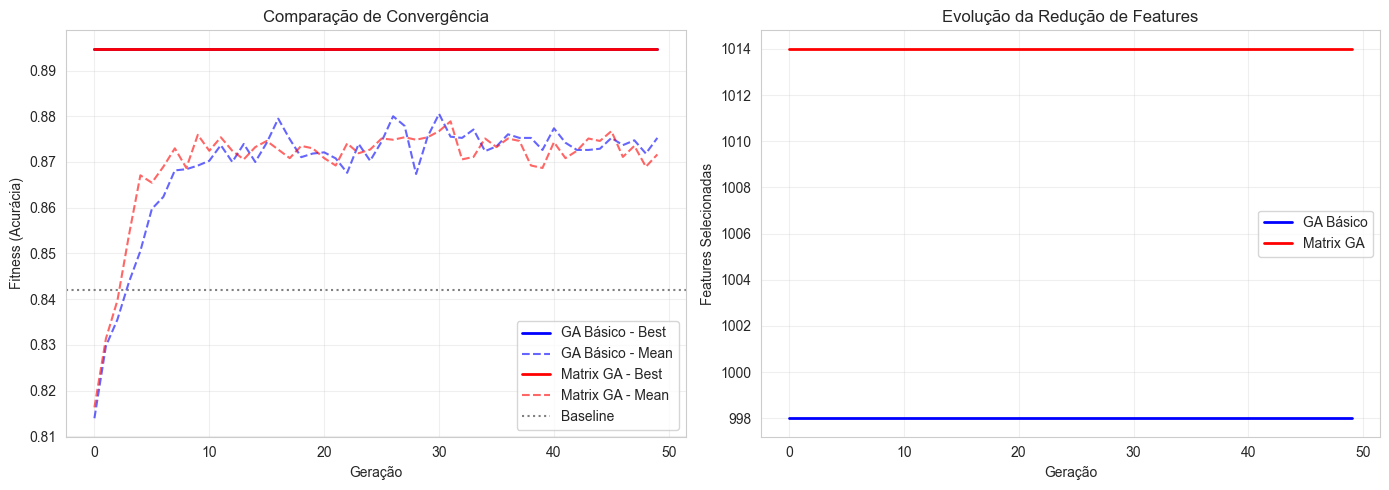

In [22]:
history_basic = ga_basic.get_fitness_history()
history_mga = mga.get_fitness_history()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

generations_basic = [h['generation'] for h in history_basic]
best_fitness_basic = [h['best_fitness'] for h in history_basic]
mean_fitness_basic = [h['mean_fitness'] for h in history_basic]

generations_mga = [h['generation'] for h in history_mga]
best_fitness_mga = [h['best_fitness'] for h in history_mga]
mean_fitness_mga = [h['mean_fitness'] for h in history_mga]

axes[0].plot(generations_basic, best_fitness_basic, 'b-', linewidth=2, label='GA Básico - Best')
axes[0].plot(generations_basic, mean_fitness_basic, 'b--', linewidth=1.5, alpha=0.6, label='GA Básico - Mean')
axes[0].plot(generations_mga, best_fitness_mga, 'r-', linewidth=2, label='Matrix GA - Best')
axes[0].plot(generations_mga, mean_fitness_mga, 'r--', linewidth=1.5, alpha=0.6, label='Matrix GA - Mean')
axes[0].axhline(y=acc_test_baseline, color='gray', linestyle=':', label='Baseline')
axes[0].set_xlabel('Geração')
axes[0].set_ylabel('Fitness (Acurácia)')
axes[0].set_title('Comparação de Convergência')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

n_features_basic = [h['n_features_best'] for h in history_basic]
n_features_mga = [h['n_features_best'] for h in history_mga]

axes[1].plot(generations_basic, n_features_basic, 'b-', linewidth=2, label='GA Básico')
axes[1].plot(generations_mga, n_features_mga, 'r-', linewidth=2, label='Matrix GA')
axes[1].set_xlabel('Geração')
axes[1].set_ylabel('Features Selecionadas')
axes[1].set_title('Evolução da Redução de Features')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()